In [1]:
import os
import astropy
import numpy as np
from astropy.table import Table
from astropy.table import Column
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [2]:
moe = .5

In [3]:
sample_location = "/home/hallflower/sample/spectra/"
dash = "/mnt/c/users/20xha/Documents/Caltech/Research/DASH/"

In [4]:
SEDM_ML_sample = Table.read("/mnt/c/Users/20xha/Documents/Caltech/Research/SEDM_ML_sample.ascii", format = "ascii")
SEDM_ML_sample.rename_column('col1', 'ZTF_Name')
SEDM_ML_sample.rename_column('col2', "Class")
SEDM_ML_sample.rename_column('col8', "Version")

In [5]:
snidoutput = np.load("/mnt/c/Users/20xha/Documents/Caltech/Research/SNID_results_rlap3.npy", allow_pickle=True)

In [6]:
final_rcf_table = Table.from_pandas(pd.read_hdf("/mnt/c/users/20xha/Documents/Caltech/Research/final_rcf_table.h5"))

In [7]:
final_rcf_table[0]

ZTF_Name,TNS_Name,discovered_by,tns_internal_name,RA_sn,Dec_sn,sn_type,z_sn,g_jd_max,g_max,g_unc_max,r_jd_max,r_max,r_unc_max,ebv,host_name_PS1,RA_host_PS1,Dec_host_PS1,z_host,sep,projected_kpc,gKron_PS1,rKron_PS1,iKron_PS1,zKron_PS1,yKron_PS1,w1_host,w2_host,ebv_host
str12,str9,str13,str29,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18aabssth,SN2018aex,ZTF,ZTF18aabssth,165.1891017637735,22.287497041839774,II,0.026000000000000002,2458494.0531481,20.44230842590332,0.1942138969898224,2458218.7148727,18.741601943969727,0.0452471598982811,0.01536,PSO J165.1878+22.2877,165.18778907,22.28771869,0.022914,4.444857426598462,2.0566548608097266,16.885400772094727,16.492399215698242,16.382200241088867,16.378400802612305,16.610000610351562,15.79401524178536,16.38349243564084,0.015369999999999997


In [8]:
ranges = np.linspace(0, 25, 101)
z_output_snid = []
count = 0

for i in ranges:
    ZTable = Table(
                    names=("ZTF_Name", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
    for j in snidoutput:
        row = []
        row.append(j[0])
        if(np.max(j[1]["rlap"]) > i):
            good = j[1][np.where(j[1]["grade"] == "good")]
            if(len(good) != 0):
                row.append(float(np.mean(good[0]["z"])))
                row.append(float(np.sqrt(np.mean(good[0]["zerr"] ** 2))))
                ZTable.add_row(row)
    
    count += 1
    if(len(ZTable) != 0):
        z_output_snid.append([i,ZTable])
    if(count% 100 == 0):
        print(count)
z_output_snid = np.asarray(z_output_snid)

100


In [9]:
z_joinedoutput_snid = []
for i in z_output_snid:
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    z_joinedoutput_snid.append([i[0], JoinedResults])
z_joinedoutput_snid = np.asarray(z_joinedoutput_snid)

In [10]:
z_accuracy_snid = []
for table in z_joinedoutput_snid:
    right = 0
    wrong = []
    for row in table[1]:
        zerror = np.abs((row["z_snid"] - row["z_host"])/row["z_host"])
        if(zerror < moe):
            right += 1
        else:
            wrong.append(np.asarray([row["z_snid"], row["z_snid_err"], row["z_sn"]]))
    wrong = np.asarray(wrong)
    z_accuracy_snid.append([table[0],right,len(table[1]),wrong])
z_accuracy_snid = np.asarray(z_accuracy_snid)

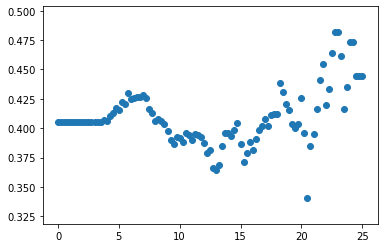

In [11]:
plt.scatter(z_accuracy_snid[:,0], z_accuracy_snid[:,1]/z_accuracy_snid[:,2])

In [12]:
dashoutput = np.load(dash+"output.npy",allow_pickle=True)

In [13]:
ranges = np.linspace(0, 25, 101)
z_output_dash = []
count = 0

for rlap in ranges:
    ZTable = Table(
                    names=("ZTF_Name", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
    for i in dashoutput:
        row = []
        row.append(i[-1])
        rlap_list = []
        for rlap_vals in np.asarray(i[3]):
            rlap_list.append(float(rlap_vals.split(":")[-1]))
        best_rlap = np.max(rlap_list)
        if(best_rlap > rlap):
            zlist = i[1]
            row.append(float((i[1][0])))
            row.append(float(np.std(i[1])))
            ZTable.add_row(row)
    
    count += 1
    if(len(ZTable) != 0):
        z_output_dash.append([rlap,ZTable])
    if(count% 100 == 0):
        print(count)
z_output_dash = np.asarray(z_output_dash)

100


In [14]:
z_joinedoutput_dash = []
for i in z_output_dash:
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    z_joinedoutput_dash.append([i[0], JoinedResults])
z_joinedoutput_dash = np.asarray(z_joinedoutput_dash)

In [15]:
z_accuracy_dash = []
for table in z_joinedoutput_dash:
    right = 0
    wrong = []
    if(len(table[1]) != 0):
        for row in table[1]:
            zsnid = row["z_snid"]
            zactual = row["z_sn"]
            zerror = np.abs((row["z_snid"] - row["z_host"])/row["z_host"])
            if(zerror < moe):
                right += 1
            else:
                wrong.append(np.asarray([row["z_snid"], row["z_snid_err"], row["z_sn"]]))
        wrong = np.asarray(wrong)
        z_accuracy_dash.append([table[0],right,len(table[1]),wrong])
z_accuracy_dash = np.asarray(z_accuracy_dash)

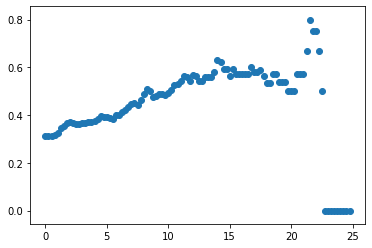

In [16]:
plt.scatter(z_accuracy_dash[:,0], z_accuracy_dash[:,1]/z_accuracy_dash[:,2])

In [17]:
right_actual = 0
wrong = []
for row in final_rcf_table:
    zerror = np.abs((row["z_sn"] - row["z_host"])/row["z_host"])
    if(zerror < moe):
        right_actual += 1
    else:
        wrong.append(np.asarray([row["z_sn"], row["z_host"]]))
wrong = np.asarray(wrong)

/home/hallflower/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


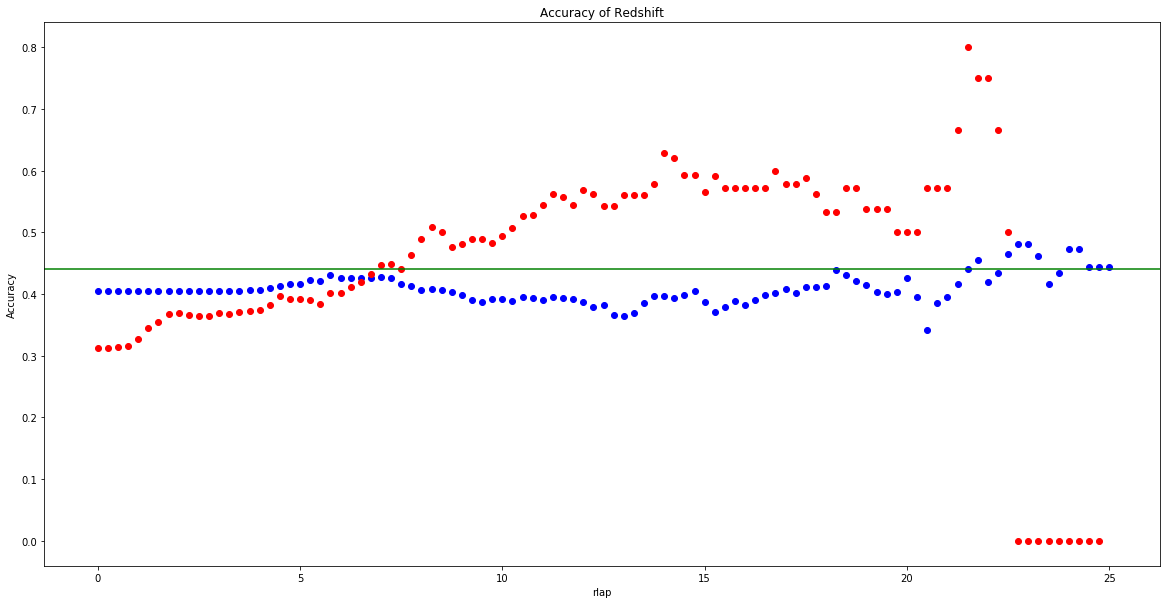

In [18]:
fig = plt.figure(figsize = (20,10))
plt.title("Accuracy of Redshift")
plt.xlabel("rlap")
plt.ylabel("Accuracy")
plt.scatter(z_accuracy_snid[:,0], z_accuracy_snid[:,1]/z_accuracy_snid[:,2], color = "blue")
plt.scatter(z_accuracy_dash[:,0], z_accuracy_dash[:,1]/z_accuracy_dash[:,2], color = "red")
plt.axhline(y=right_actual/len(final_rcf_table), color='green', linestyle='-')

In [19]:
final_rcf_table[0]

ZTF_Name,TNS_Name,discovered_by,tns_internal_name,RA_sn,Dec_sn,sn_type,z_sn,g_jd_max,g_max,g_unc_max,r_jd_max,r_max,r_unc_max,ebv,host_name_PS1,RA_host_PS1,Dec_host_PS1,z_host,sep,projected_kpc,gKron_PS1,rKron_PS1,iKron_PS1,zKron_PS1,yKron_PS1,w1_host,w2_host,ebv_host
str12,str9,str13,str29,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18aabssth,SN2018aex,ZTF,ZTF18aabssth,165.1891017637735,22.287497041839774,II,0.026000000000000002,2458494.0531481,20.44230842590332,0.1942138969898224,2458218.7148727,18.741601943969727,0.0452471598982811,0.01536,PSO J165.1878+22.2877,165.18778907,22.28771869,0.022914,4.444857426598462,2.0566548608097266,16.885400772094727,16.492399215698242,16.382200241088867,16.378400802612305,16.610000610351562,15.79401524178536,16.38349243564084,0.015369999999999997


In [20]:
z_joinedoutput_snid[0][1][0]

ZTF_Name,z_snid,z_snid_err,TNS_Name,discovered_by,tns_internal_name,RA_sn,Dec_sn,sn_type,z_sn,g_jd_max,g_max,g_unc_max,r_jd_max,r_max,r_unc_max,ebv,host_name_PS1,RA_host_PS1,Dec_host_PS1,z_host,sep,projected_kpc,gKron_PS1,rKron_PS1,iKron_PS1,zKron_PS1,yKron_PS1,w1_host,w2_host,ebv_host
str64,float64,float64,str9,str13,str29,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTF18aaemivw,0.0651,0.0061,SN2018hus,ZTF,ZTF18aaemivw,158.42789222392466,39.490720101006524,Ia,0.065,2458423.9633449,19.004362106323242,0.16449931263923645,2458534.8729861,17.948341369628906,0.14575205743312836,0.01219,PSO J158.4280+39.4908,158.42799693,39.49076448,0.068069,0.33188151968390245,0.43235062920637946,16.656200408935547,16.03030014038086,15.668299674987793,15.532500267028809,15.354399681091309,14.936141156716285,15.07967533373213,0.01219


(-0.01, 0.2)

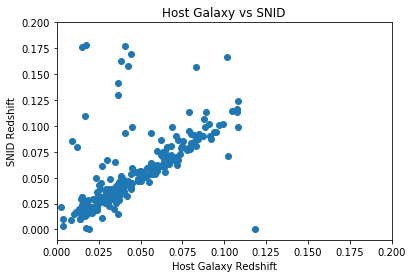

In [21]:
plt.scatter(z_joinedoutput_dash[0][1]["z_host"], z_joinedoutput_dash[0][1]["z_snid"])
plt.title("Host Galaxy vs SNID")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.xlim(0,.2)
plt.ylim(-.01,.2)

In [22]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
regr = linear_model.LinearRegression(fit_intercept = False)
z_joinedoutput_snid_good = z_joinedoutput_snid[0][1][np.where(z_joinedoutput_snid[0][1]["z_host"] > -.1)[0]]
regr.fit(z_joinedoutput_snid_good["z_host"].reshape(-1, 1), z_joinedoutput_snid_good["z_snid"].reshape(-1, 1))

/home/hallflower/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [24]:
ranges = np.linspace(np.min(z_joinedoutput_snid_good["z_host"]), np.max(z_joinedoutput_snid_good["z_host"]), 100)
ypredict = regr.predict(ranges.reshape(-1, 1))

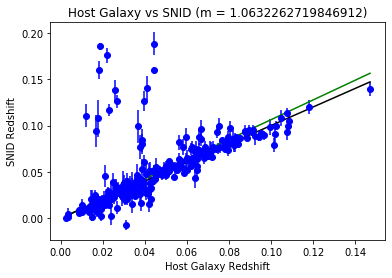

In [25]:
plt.errorbar(z_joinedoutput_snid_good["z_host"], z_joinedoutput_snid_good["z_snid"], z_joinedoutput_snid_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr.coef_[0][0]) + ")")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges, ypredict, color = "green")
plt.plot(ranges, ranges, color = "black")

In [26]:
regr_dash = linear_model.LinearRegression(fit_intercept = False)
z_joinedoutput_dash_good = z_joinedoutput_dash[0][1][np.where(z_joinedoutput_dash[0][1]["z_host"] > -.1)[0]]
regr_dash.fit(z_joinedoutput_dash_good["z_host"].reshape(-1, 1), z_joinedoutput_dash_good["z_snid"].reshape(-1, 1))

/home/hallflower/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [27]:
ranges_dash = np.linspace(np.min(z_joinedoutput_dash_good["z_host"]), np.max(z_joinedoutput_dash_good["z_host"]), 100)
ypredict_dash = regr_dash.predict(ranges.reshape(-1, 1))

Text(0, 0.5, 'Dash Redshift')

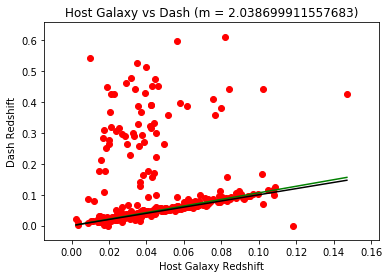

In [28]:
plt.scatter(z_joinedoutput_dash_good["z_host"], z_joinedoutput_dash_good["z_snid"], color = "red")
plt.plot(ranges, ypredict, color = "green")
plt.plot(ranges, ranges, color = "black")
plt.title("Host Galaxy vs Dash (m = " + str(regr_dash.coef_[0][0]) + ")")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("Dash Redshift")

Text(0.5, 1.0, 'Dash Residuals (deltaZ > 0.1)')

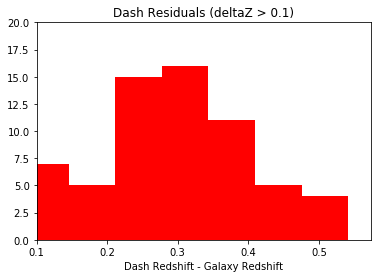

In [66]:
plt.hist((z_joinedoutput_dash_good["z_snid"] - z_joinedoutput_dash_good["z_host"]), color = "red")
plt.xlim(.1)
plt.ylim(0,20)
plt.xlabel("Dash Redshift - Galaxy Redshift")
plt.title("Dash Residuals (deltaZ > 0.1)")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)')

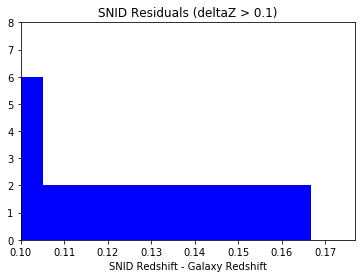

In [65]:
plt.hist((z_joinedoutput_snid_good["z_snid"] - z_joinedoutput_snid_good["z_host"]), color = "blue")
plt.xlim(.1)
plt.ylim(0,8)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)")

Text(0.5, 1.0, 'Dash delta Z ratio (> 2)')

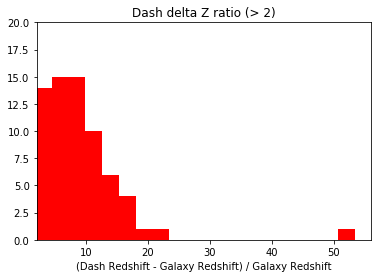

In [77]:
plt.hist((z_joinedoutput_dash_good["z_snid"] - z_joinedoutput_dash_good["z_host"])/z_joinedoutput_dash_good["z_host"], color = "red", bins = 20)
plt.xlim(2)
plt.ylim(0,20)
plt.xlabel("(Dash Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("Dash delta Z ratio (> 2)")

Text(0.5, 1.0, 'SNID delta Z ratio (> 2)')

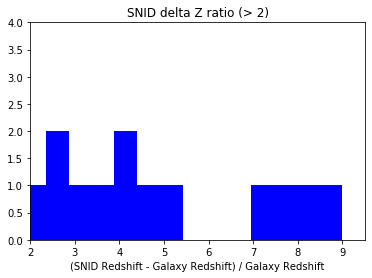

In [76]:
plt.hist((z_joinedoutput_snid_good["z_snid"] - z_joinedoutput_snid_good["z_host"])/z_joinedoutput_snid_good["z_host"], color = "blue", bins = 20)
plt.xlim(2)
plt.ylim(0,4)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID delta Z ratio (> 2)")